In [1]:
import cv2
import numpy as np
from time import time
from pathlib import Path
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def imshow(bgr):
    rgb = bgr[:, :, [2, 1, 0]]
    plt.imshow(rgb)

In [3]:
def xy_from_opencv_points(cv_points):
    return np.array([[point.pt[0], point.pt[1]] for point in cv_points], np.float32)

def optical_flow_dual_check(img0, img1):
    gftt_max_corners = 2391
    lkparams = dict(winSize=(15,15),
                    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    detector = cv2.GFTTDetector_create(maxCorners=gftt_max_corners)
    p0 = detector.detect(img0)
    p0 = xy_from_opencv_points(detector.detect(img0))
    if len(p0) == 0:
        return [], []
    
    p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lkparams)
    mask = (st == 1).reshape(-1)
    p0, p1 = p0[mask], p1[mask]
    if mask.sum() == 0:
        return [], []
    
    p10, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lkparams)
    mask = (st == 1).reshape(-1)
    p0, p1, p10 = p0[mask], p1[mask], p10[mask]
    if mask.sum() == 0:
        return [], []
    
    mask = np.linalg.norm(p10 - p0, axis=-1) < 2.0
    p0, p1, p10 = p0[mask], p1[mask], p10[mask]
    if mask.sum() == 0:
        return [], []
    return p0, p1

def to_int(xy):
    return tuple(map(int, xy))

def draw_motion(img, p0, p1):
    for a, b in zip(p0, p1):
        cv2.line(img, to_int(a), to_int(b), (255, 0, 0))
    return img

In [4]:
def read_video(filename):
    video = cv2.VideoCapture(filename)
    assert video.isOpened()
    while True:
        ret, frame = video.read()
        if frame is None:
            return
        else:
            yield frame

def iter_pairs(xs):
    prev = next(xs)
    while True:
        cur = next(xs)
        yield prev, cur
        prev = cur

Frames size: 960x720


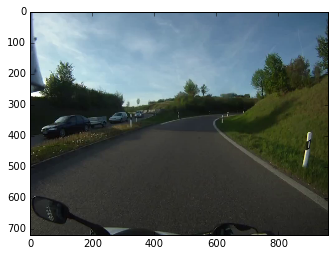

In [5]:
work_dir = Path("data_motorcycle/")
video_path = str(work_dir / "source.mp4")
framerate = 30
frames_limit = 300

frame = next(read_video(video_path))
wh = frame.shape[:2][::-1]
print("Frames size: {}x{}".format(*wh))
imshow(frame)

In [6]:
dxys = []
motion_video = cv2.VideoWriter(str(work_dir / 'motion.mp4'),
                               cv2.VideoWriter_fourcc('x', '2', '6', '4'),
                               framerate, wh)

start = time()
for i, (img0, img1) in zip(range(239**3 if frames_limit is None else frames_limit),
                           iter_pairs(read_video(video_path))):
    p0, p1 = optical_flow_dual_check(img0, img1)
    if len(p0) == 0:
        dxys.append([0, 0])
    else:
        dxys.append(np.median(p1 - p0, axis=0))
    motion_video.write(draw_motion(img0.copy(), p0, p1))
    
    if (i % 100 == 0):
        print("{} frames for {:.1f} seconds".format(i, time() - start))
    
motion_video.release()

0 frames for 0.4 seconds
100 frames for 13.2 seconds
200 frames for 27.8 seconds


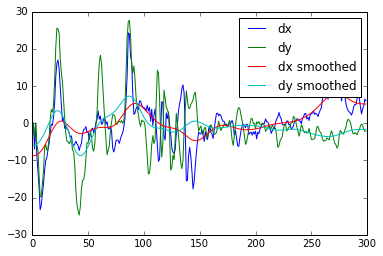

In [7]:
def smooth(xyzs, median_size=5, gaussian_size=59):
    one_channel = len(xyzs.shape) == 1
    if one_channel:
        xyzs = xyzs.reshape(-1, 1)
    xyzs = xyzs.copy()
    for i in range(xyzs.shape[1]):
        xyzs[:, i] = cv2.medianBlur(xyzs[:, i], median_size).reshape(-1)
        xyzs[:, i] = cv2.GaussianBlur(xyzs[:, i], (1, gaussian_size), 0).reshape(-1)
    if one_channel:
        xyzs = xyzs.reshape(-1)
    return xyzs

dxys = np.array(dxys, np.float32)
dxys_smoothed = smooth(dxys)

plt.plot(dxys[:, 0], label='dx')
plt.plot(dxys[:, 1], label='dy')
plt.plot(smooth(dxys[:, 0]), label='dx smoothed')
plt.plot(smooth(dxys[:, 1]), label='dy smoothed')
plt.legend();

In [9]:
w, h = wh
double_wh = (2 * w, h)
result_video = cv2.VideoWriter(str(work_dir / 'result.mp4'),
                               cv2.VideoWriter_fourcc('x', '2', '6', '4'),
                               framerate, double_wh)
assert result_video.isOpened()

start = time()
previous_dxy_hided = np.array([0, 0], np.float32)
for i, dxy, dxy_smoothed, (img0, img1) in zip(range(239**3 if frames_limit is None else frames_limit),
                                              dxys, dxys_smoothed,
                                              iter_pairs(read_video(video_path))):
    dxy = dxy + previous_dxy_hided
    previous_dxy_hided = dxy - dxy_smoothed
    dx, dy = -previous_dxy_hided

    M = np.array([[1, 0, dx + w],
                  [0, 1, dy]], np.float32)
    img1_stabilized = cv2.warpAffine(img1, M, double_wh)
    img1_stabilized[:, :w] = img1
    result_video.write(img1_stabilized)
    
    if (i * 100 // len(dxys) != (i - 1) * 100 // len(dxys)):
        print("{}% for {:.1f} seconds".format(i * 100 // len(dxys), time() - start))

result_video.release()

0% for 0.0 seconds
1% for 0.1 seconds
2% for 0.1 seconds
3% for 0.2 seconds
4% for 0.2 seconds
5% for 0.3 seconds
6% for 0.3 seconds
7% for 0.3 seconds
8% for 0.4 seconds
9% for 0.4 seconds
10% for 0.5 seconds
11% for 0.5 seconds
12% for 0.6 seconds
13% for 0.6 seconds
14% for 0.7 seconds
15% for 1.1 seconds
16% for 1.2 seconds
17% for 1.4 seconds
18% for 1.6 seconds
19% for 1.8 seconds
20% for 2.2 seconds
21% for 2.4 seconds
22% for 2.6 seconds
23% for 2.8 seconds
24% for 3.0 seconds
25% for 3.3 seconds
26% for 3.5 seconds
27% for 3.7 seconds
28% for 3.9 seconds
29% for 4.1 seconds
30% for 4.3 seconds
31% for 4.6 seconds
32% for 4.8 seconds
33% for 5.0 seconds
34% for 5.2 seconds
35% for 5.4 seconds
36% for 5.7 seconds
37% for 5.9 seconds
38% for 6.2 seconds
39% for 6.4 seconds
40% for 6.7 seconds
41% for 6.8 seconds
42% for 7.2 seconds
43% for 7.3 seconds
44% for 7.6 seconds
45% for 7.8 seconds
46% for 8.1 seconds
47% for 8.3 seconds
48% for 8.6 seconds
49% for 8.8 seconds
50% for 9.

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("qCEyiqYzjoo")